In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchvision.utils import save_image
import os
import cv2
from ultralytics import YOLO
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from premium_gan_generator import Generator
from apply_bb import apply_bounding_box_mask
from load_image import load_image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Hàm hiển thị ba ảnh theo yêu cầu
def display_images(generator, model_yolo, img_loader, save_folder):
    # Lấy một batch từ dataloader
    with_mask_batch = next(iter(img_loader))
    with_mask_batch = with_mask_batch.to(device)  # Đảm bảo ảnh được chuyển sang GPU nếu có
    plt.figure(figsize=(15, 30))  # Tăng kích thước hiển thị (rộng x cao)

    os.makedirs(save_folder, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

    idx = 0  # Chỉ số của ảnh trong batch

    # 1. Hiển thị ảnh gốc từ dataloader (ảnh có khẩu trang)
    img_original = with_mask_batch[idx].cpu()  # Chuyển về CPU
    img_original = img_original * 0.5 + 0.5  # Bỏ chuẩn hóa, đưa ảnh về [0, 1]
    img_original = img_original.permute(1, 2, 0).numpy()  # Chuyển từ (C, H, W) -> (H, W, C)

    plt.subplot(10, 3, idx * 3 + 1)
    plt.imshow(img_original)
    plt.title("1. Masked img")
    plt.axis("off")

    # 2. Áp dụng bounding box mask lên ảnh có khẩu trang
    images_with_mask = apply_bounding_box_mask(with_mask_batch, model_yolo)
    img_with_mask = images_with_mask[idx].cpu()  # Chuyển về CPU
    img_with_mask = img_with_mask * 0.5 + 0.5  # Bỏ chuẩn hóa
    img_with_mask = img_with_mask.numpy()  # Chuyển từ (C, H, W) -> (H, W, C)

    plt.subplot(10, 3, idx * 3 + 2)
    plt.imshow(img_with_mask)
    plt.title("2. Image with BB")
    plt.axis("off")

    # 3. Truyền ảnh qua generator để sinh ảnh mới
    images_with_mask = images_with_mask.to(device)
    generated_images = generator(images_with_mask.permute(0, 3, 1, 2))  # (B, H, W, C) -> (B, C, H, W)
    generated_image = generated_images[idx].cpu().detach()  # Chuyển về CPU
    generated_image = generated_image * 0.5 + 0.5  # Bỏ chuẩn hóa, đưa ảnh về [0, 1]

    # Lưu ảnh
    save_path = os.path.join(save_folder, f"generated_image_{idx + 1}.png")
    save_image(generated_image, save_path)  # Không cần chuyển đổi thêm
    print(f"Saved generated image to: {save_path}")

    # Hiển thị ảnh được sinh
    generated_img = generated_image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    plt.subplot(10, 3, idx * 3 + 3)
    plt.imshow(generated_img)
    plt.title("3. Generated Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Saved generated image to: C:/Sam C-Gan project/save_folder\generated_image_1.png


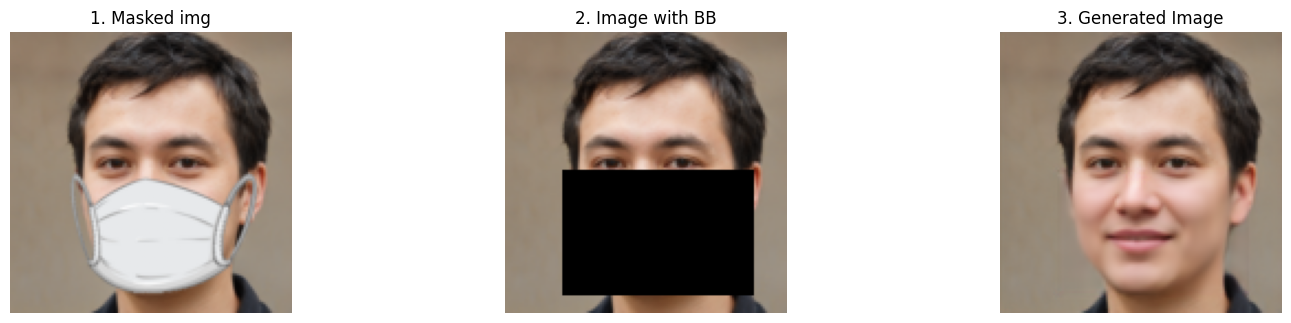

In [7]:
def main():
    # Load mô hình generator đã huấn luyện
    generator = Generator()
    generator.load_state_dict(torch.load('C:\\Sam C-Gan project\\checkpoints\\generator_epoch_60.pth'))
    generator.to(device)
    generator.eval()  # Đặt mô hình ở chế độ đánh giá

    model_yolo=YOLO('C:\\Sam C-Gan project\\bounding black box\\mask_detection.pt')
    img_path= "C:/Sam C-Gan project/data/with_mask/val/with-mask-default-mask-seed9003.png"
    save_folder="C:/Sam C-Gan project/save_folder"
    img_loader=load_image(img_path)
    display_images(generator, model_yolo, img_loader,save_folder)
main()